````bash
aiffel
└── sentiment_classification
    ├── project08.ipynb   <─ I am here
    └── data
        ├── ratings_test.txt
        └── ratings_train.txt       
````

### 사용 라이브러리 버전
```pyt|hon
pandas.__version__ : 1.3.3
konlpy.__version__ : 0.5.2
gensim.__version__ : 4.1.2
```

In [1]:
import pandas as pd

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

# train_data.shape : (150000, 3)
# test_data.shape  :  (50000, 3)
# col1 : Id
# col2 : document
# col3 : labe
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


### 형태를 확인해봅시다.

- `train_data.shape`은 `150,000` rows 와 `3` columns
- `test_data.shape`은 `50,000` row와 `3` columns




In [2]:
print(train_data.shape)
print(test_data.shape)

(150000, 3)
(50000, 3)


In [3]:
import matplotlib.pyplot as plt



### 자신만의 data_loader를 만들어보자.
- 데이터 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어 제거
- 사전 word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [4]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

In [5]:
# 형태소 분석기 Mecab룰 통한 토크나이저
tokenizer = Mecab()

In [6]:
# 불용어 제거
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

In [7]:
def load_data(train_data, test_data, num_words=None):
    # train, test 데이터내 중복 제거 및 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
        
    # 1차원의 list 형태로 변환
    # Before : [['가', '가', '나', '다'], ['가', '라', '마'], ['마', '사']]
    # After  : ['가', '가', '나', '다', '가', '라', '마', '마', '사']
    words = np.concatenate(X_train).tolist()

    # 위에서 변환된 ['가', '가', '나', '다', '가', '라', '마', '마', '사'] list가 있다고 할때
    # Counter()를 거치고 나면 Counter({'가': 3, '마': 2, '나': 1, '다': 1, '라': 1, '사': 1}) 객체가 된다.
    # Counter객체를 most_common(3)함수를 사용하면 최빈값 3번째 까지 리스트에 담긴 튜플 형태로 반환된다.
    # output : [('가', 3), ('마', 2), ('나', 1)]
    counter = Counter(words)
    counter = counter.most_common(num_words-4)
    
    # counter = [('가', 3), ('마', 2), ('나', 1)] 일때
    # [k for k, _ in counter]의 output은 ['가', '마', '나']이 된다.
    # 같은 차원의 리스트 합 연산은 ['', ''] + ['가', '마', '나'] => ['', '', '가', '마', '나']형태가 된다.
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

In [8]:
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, 10000) 

In [9]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [10]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [11]:
#실제 인코딩 인덱스는 제공된 word_to_index에서 index 기준으로 3씩 뒤로 밀려 있습니다.  
# 딕셔너리는 { 단어 : Index번호 }순으로 되어 있다.
# dic = {'':0, '':1, '':2, '':3, '가':4, '나':5}
# {k:(v+1) for k,v in dic.items()}을 거치면 {'': 4, '가': 5, '나': 6} 형태가 된다.
word_to_index = {k:(v+1) for k,v in word_to_index.items()}

# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
# 딕셔너리 맨 뒤에 아래 4개의 새로운 key-value를 추가합니다.
# 아래 4개의 key-value는 맨 뒤에 붙는다.
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[1])     # '<BOS>' 가 출력됩니다.

<BOS>


In [12]:
# X_Train, X_Test를 하나의 list에 통합.
# [[1, 33, 22, 13], [11, 23]] 와 [[32, 11, 23]] = [[1, 33, 22, 13], [11, 23], [32, 11, 23]]
total_train_text = np.concatenate((X_train, X_test), axis=0).tolist()

# total_train_text의 개별 list의 길이를 개별로 구축
sep_len_ttt = np.array([len(tokens) for tokens in total_train_text])

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


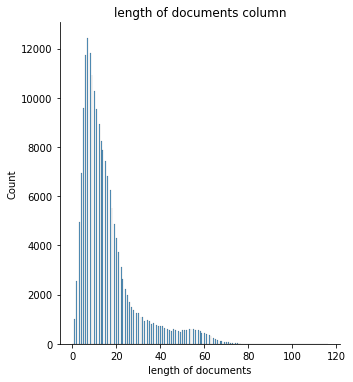

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

dst = sns.displot(data=sep_len_ttt)
dst.set(title="length of documents column").set_xlabels('length of documents')
plt.show()

In [14]:
# 최빈값을 구하기 위해 Numpy의 bincount와 argmax를 이용

print(f" 0부터 Max까지 빈도 수 \n{np.bincount(sep_len_ttt)}")
print(f" 최빈수 : {np.bincount(sep_len_ttt).argmax()}")
print(f" 특이값(outlier) : {np.max(sep_len_ttt)}")
print(f" 중앙값(median) : {np.median(sep_len_ttt)}")
print(f" 평균(mean) : {np.mean(sep_len_ttt)}")
print(f" 표준편차(sigma) : {np.std(sep_len_ttt)}")

 0부터 Max까지 빈도 수 
[    5  1015  2554  4951  6936  9580 11741 12441 11822 10907 10287  9531
  8928  8253  7868  7440  6823  6258  5535  4869  4312  3746  3136  2653
  2242  1993  1688  1512  1376  1270  1241  1108  1074   947   951   927
   814   854   763   714   728   712   623   583   580   537   593   576
   528   499   547   560   573   587   597   583   569   567   539   455
   438   409   358   306   254   193   171   132    97    88    58    63
    39    26    15    26    22     8     8     7     4     2     2     1
     1     1     2     0     2     0     0     0     0     1     0     0
     0     0     0     0     0     0     0     0     0     1     1     0
     0     0     0     0     0     0     0     1     1]
 최빈수 : 7
 특이값(outlier) : 116
 중앙값(median) : 12.0
 평균(mean) : 15.96940191154864
 표준편차(sigma) : 12.843571191092


#### 분포 해석
- 데이터가 오른쪽 꼬리 분포이므로 평균이 아닌 중앙값을 이용하여 최대 길이를 선정
    - 중앙값(median)은 이상치(outlier)의 영향을 받지 않는다.

## 1. RNN(LSTM)으로 모델 돌려보기

In [15]:
import tensorflow as tf

X_train과 X_test를 <u>문장앞</u>에 패딩(`<PAD>`)을 추가하여 일정한 길이를 맞춘다.

In [16]:
X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='pre',
                                                        maxlen=30)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='pre',
                                                       maxlen=30)

In [17]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 30  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(15))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 30)          300000    
_________________________________________________________________
lstm (LSTM)                  (None, 15)                2760      
_________________________________________________________________
dense (Dense)                (None, 8)                 128       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 302,897
Trainable params: 302,897
Non-trainable params: 0
_________________________________________________________________


### 학습용, 검증용, 시험용 데이터셋 구분
- 모델 합습에 사용되는 `Train set`과 학습 완료 후 모델 검증을 위한 `Validation(Val) set` 그리고 마지막으로 학습과 검증 완료 후 모델의 최종 성능 평가를 위한 `Test set` 으로 나눈다.

In [18]:
print(len(X_train))
print(len(X_test))

146182
49157


In [19]:
print(len(y_train))
print(len(y_test))

146182
49157


In [20]:
X_val = X_train[:49157]
y_val = y_train[:49157]

partial_X_train = X_train[49157:]  
partial_y_train = y_train[49157:]

In [21]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [22]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=25,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/25
190/190 [==============================] - 30s 9ms/step - loss: 0.5056 - accuracy: 0.7601 - val_loss: 0.3630 - val_accuracy: 0.8434
Epoch 2/25
190/190 [==============================] - 1s 6ms/step - loss: 0.3404 - accuracy: 0.8557 - val_loss: 0.3479 - val_accuracy: 0.8493
Epoch 3/25
190/190 [==============================] - 1s 6ms/step - loss: 0.3097 - accuracy: 0.8706 - val_loss: 0.3464 - val_accuracy: 0.8504
Epoch 4/25
190/190 [==============================] - 1s 6ms/step - loss: 0.2902 - accuracy: 0.8802 - val_loss: 0.3519 - val_accuracy: 0.8491
Epoch 5/25
190/190 [==============================] - 1s 6ms/step - loss: 0.2720 - accuracy: 0.8887 - val_loss: 0.3631 - val_accuracy: 0.8483
Epoch 6/25
190/190 [==============================] - 1s 6ms/step - loss: 0.2571 - accuracy: 0.8957 - val_loss: 0.3672 - val_accuracy: 0.8471
Epoch 7/25
190/190 [==============================] - 1s 6ms/step - loss: 0.2434 - accuracy: 0.9017 - val_loss: 0.3792 - val_accuracy: 0.8448
Epoch

In [23]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7622 - accuracy: 0.8228
[0.76219642162323, 0.8227719068527222]


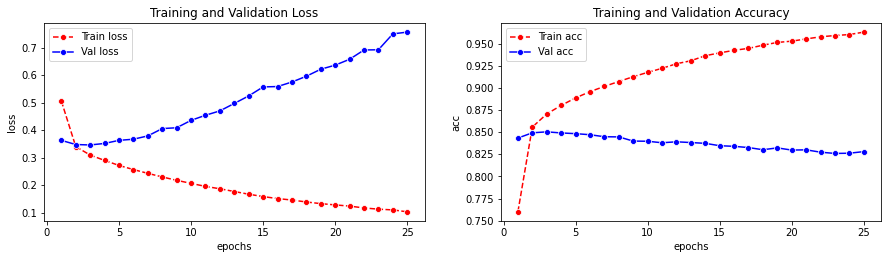

In [24]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
sns.lineplot(x=epochs, y=loss, color='r', linestyle='--', marker='o')
sns.lineplot(x=epochs, y=val_loss, color='b', linestyle='-', marker='o')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training and Validation Loss")
plt.legend(labels=['Train loss', 'Val loss'])

plt.subplot(2, 2, 2)
sns.lineplot(x=epochs, y=acc, color='r', linestyle='--', marker='o')
sns.lineplot(x=epochs, y=val_acc, color='b', linestyle='-', marker='o')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.title("Training and Validation Accuracy")
plt.legend(labels=['Train acc', 'Val acc'])

plt.show()

In [25]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.7622 - accuracy: 0.8228
[0.76219642162323, 0.8227719068527222]


### LSTM 결과

오히려 epoch이 늘어남에 따라 검증용 데이터에 대한 정확도가 줄어듬을 볼 수 있었다.

Train과 Val ACC가 2번째 epoch 이후 Validation Acc가 줄어드는 것으로 보아, 과적합(오버피팅)이 발생함을 알 수 있다.

## 2. RNN이 아닌 방법으로 모델 돌려보기

### 2-1. CNN(1-D)으로 모델 돌려보기

In [26]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.Conv1D(16, 4, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 4, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 30)          300000    
_________________________________________________________________
conv1d (Conv1D)              (None, None, 16)          1936      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, None, 16)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, None, 16)          1040      
_________________________________________________________________
global_max_pooling1d (Global (None, 16)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [27]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [28]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=25,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/25
190/190 [==============================] - 17s 7ms/step - loss: 0.5452 - accuracy: 0.7274 - val_loss: 0.4081 - val_accuracy: 0.8096
Epoch 2/25
190/190 [==============================] - 1s 5ms/step - loss: 0.3749 - accuracy: 0.8322 - val_loss: 0.3941 - val_accuracy: 0.8183
Epoch 3/25
190/190 [==============================] - 1s 5ms/step - loss: 0.3319 - accuracy: 0.8555 - val_loss: 0.3959 - val_accuracy: 0.8185
Epoch 4/25
190/190 [==============================] - 1s 5ms/step - loss: 0.2945 - accuracy: 0.8747 - val_loss: 0.4106 - val_accuracy: 0.8158
Epoch 5/25
190/190 [==============================] - 1s 5ms/step - loss: 0.2567 - accuracy: 0.8946 - val_loss: 0.4322 - val_accuracy: 0.8137
Epoch 6/25
190/190 [==============================] - 1s 5ms/step - loss: 0.2165 - accuracy: 0.9143 - val_loss: 0.4683 - val_accuracy: 0.8085
Epoch 7/25
190/190 [==============================] - 1s 6ms/step - loss: 0.1794 - accuracy: 0.9308 - val_loss: 0.5134 - val_accuracy: 0.8046
Epoch

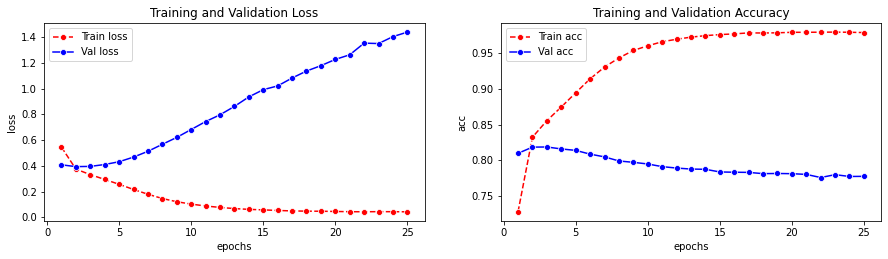

In [29]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
sns.lineplot(x=epochs, y=loss, color='r', linestyle='--', marker='o')
sns.lineplot(x=epochs, y=val_loss, color='b', linestyle='-', marker='o')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training and Validation Loss")
plt.legend(labels=['Train loss', 'Val loss'])

plt.subplot(2, 2, 2)
sns.lineplot(x=epochs, y=acc, color='r', linestyle='--', marker='o')
sns.lineplot(x=epochs, y=val_acc, color='b', linestyle='-', marker='o')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.title("Training and Validation Accuracy")
plt.legend(labels=['Train acc', 'Val acc'])

plt.show()

In [30]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 1.4667 - accuracy: 0.7769
[1.466726303100586, 0.7769392132759094]


### 2-2. GlobalMaxPooling1D로 모델 돌려보기

In [31]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 30)          300000    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 30)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 248       
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 9         
Total params: 300,257
Trainable params: 300,257
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [33]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
286/286 [==============================] - 2s 4ms/step - loss: 0.5307 - accuracy: 0.7688 - val_loss: 0.3664 - val_accuracy: 0.8488
Epoch 2/20
286/286 [==============================] - 1s 4ms/step - loss: 0.3486 - accuracy: 0.8505 - val_loss: 0.3000 - val_accuracy: 0.8756
Epoch 3/20
286/286 [==============================] - 1s 4ms/step - loss: 0.3067 - accuracy: 0.8699 - val_loss: 0.2687 - val_accuracy: 0.8919
Epoch 4/20
286/286 [==============================] - 1s 4ms/step - loss: 0.2812 - accuracy: 0.8834 - val_loss: 0.2460 - val_accuracy: 0.9027
Epoch 5/20
286/286 [==============================] - 1s 4ms/step - loss: 0.2610 - accuracy: 0.8935 - val_loss: 0.2270 - val_accuracy: 0.9126
Epoch 6/20
286/286 [==============================] - 1s 4ms/step - loss: 0.2438 - accuracy: 0.9013 - val_loss: 0.2104 - val_accuracy: 0.9202
Epoch 7/20
286/286 [==============================] - 1s 4ms/step - loss: 0.2280 - accuracy: 0.9093 - val_loss: 0.1951 - val_accuracy: 0.9281
Epoch 

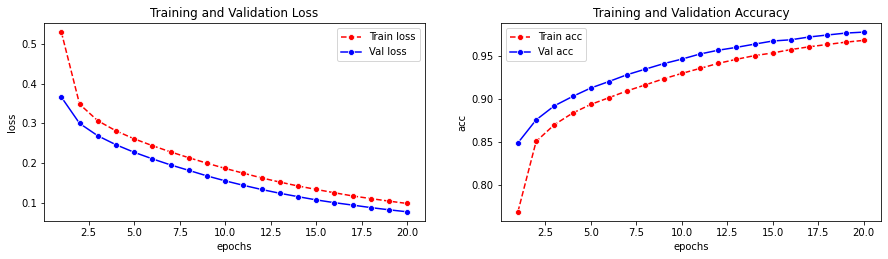

In [34]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
sns.lineplot(x=epochs, y=loss, color='r', linestyle='--', marker='o')
sns.lineplot(x=epochs, y=val_loss, color='b', linestyle='-', marker='o')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training and Validation Loss")
plt.legend(labels=['Train loss', 'Val loss'])

plt.subplot(2, 2, 2)
sns.lineplot(x=epochs, y=acc, color='r', linestyle='--', marker='o')
sns.lineplot(x=epochs, y=val_acc, color='b', linestyle='-', marker='o')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.title("Training and Validation Accuracy")
plt.legend(labels=['Train acc', 'Val acc'])

plt.show()

In [35]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.6342 - accuracy: 0.8216
[0.634221076965332, 0.8215920329093933]


### Word2Vec 사용하기

```bash
aiffel
└── sentiment_classification
    ├── project08.ipynb   <─ I am here
    └── data
        ├── ratings_test.txt
        ├── ratings_train.txt
        ├── word2vec_ko.model                          <─ word2vec
        ├── word2vec_ko.model.trainables.syn1neg.npy   <─ word2vec
        └── word2vec_ko.model.wv.vectors.npy           <─ word2vec
```

In [36]:
from gensim.models.keyedvectors import Word2VecKeyedVectors
word_vectors = Word2VecKeyedVectors.load('data/word2vec_ko.model')
vector = word_vectors.wv['영화']

In [54]:
# 사전 학습된 임베딩 벡터는 차원이 100입니다.
vocab_size = 10001
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim) # 사전학습 벡터를 복사할 더미를 만듭니다.

# embedding_matrix에 Word2Vec 워드 벡터를 단어 하나씩 차례대로 카피합니다.
for i in range(4, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]
    

# 모델 구성
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,
                                    word_vector_dim,
                                    embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                    input_length=30,
                                    trainable=True)) # trainable=True로 주면 Fine-tuning
model.add(tf.keras.layers.Conv1D(16, 4, activation='relu'))
model.add(tf.keras.layers.MaxPooling1D(5))
model.add(tf.keras.layers.Conv1D(16, 4, activation='relu'))
model.add(tf.keras.layers.GlobalMaxPooling1D())
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 30, 100)           1000100   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 27, 16)            6416      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 5, 16)             0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 2, 16)             1040      
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 16)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                

In [49]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [50]:
history = model.fit(X_train,
                    y_train,
                    epochs=20,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/20
286/286 [==============================] - 3s 6ms/step - loss: 0.6349 - accuracy: 0.6184 - val_loss: 0.5498 - val_accuracy: 0.7119
Epoch 2/20
286/286 [==============================] - 2s 5ms/step - loss: 0.5126 - accuracy: 0.7410 - val_loss: 0.4604 - val_accuracy: 0.7774
Epoch 3/20
286/286 [==============================] - 2s 5ms/step - loss: 0.4469 - accuracy: 0.7873 - val_loss: 0.4092 - val_accuracy: 0.8103
Epoch 4/20
286/286 [==============================] - 1s 5ms/step - loss: 0.4084 - accuracy: 0.8095 - val_loss: 0.3783 - val_accuracy: 0.8284
Epoch 5/20
286/286 [==============================] - 2s 5ms/step - loss: 0.3828 - accuracy: 0.8256 - val_loss: 0.3572 - val_accuracy: 0.8389
Epoch 6/20
286/286 [==============================] - 2s 5ms/step - loss: 0.3636 - accuracy: 0.8357 - val_loss: 0.3400 - val_accuracy: 0.8494
Epoch 7/20
286/286 [==============================] - 1s 5ms/step - loss: 0.3484 - accuracy: 0.8440 - val_loss: 0.3256 - val_accuracy: 0.8556
Epoch 

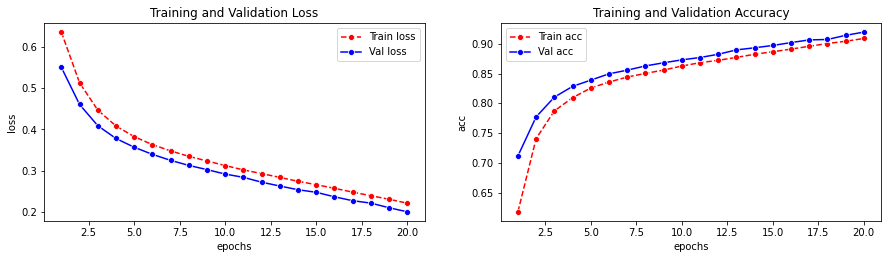

In [51]:
history_dict = history.history

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)


plt.figure(figsize=(15, 8))
plt.subplot(2, 2, 1)
sns.lineplot(x=epochs, y=loss, color='r', linestyle='--', marker='o')
sns.lineplot(x=epochs, y=val_loss, color='b', linestyle='-', marker='o')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.title("Training and Validation Loss")
plt.legend(labels=['Train loss', 'Val loss'])

plt.subplot(2, 2, 2)
sns.lineplot(x=epochs, y=acc, color='r', linestyle='--', marker='o')
sns.lineplot(x=epochs, y=val_acc, color='b', linestyle='-', marker='o')
plt.xlabel("epochs")
plt.ylabel("acc")
plt.title("Training and Validation Accuracy")
plt.legend(labels=['Train acc', 'Val acc'])

plt.show()

In [52]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5090 - accuracy: 0.8030
[0.5089560151100159, 0.8029578924179077]
